<a href="https://colab.research.google.com/github/nelsonalbertohj/EmotionNet/blob/main/Emotion_recognition_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install biosppy

     |████████████████████████████████| 1.5 MB 4.1 MB/s 
  Created wheel for biosppy: filename=biosppy-0.8.0-py2.py3-none-any.whl size=100176 sha256=42675f017b943f15c91ead9e48353509d70d0643dfdcb92742b03445bc778113
  Stored in directory: /root/.cache/pip/wheels/32/17/9d/77adbf0db713546eaa1c7a1480b2dce91fa724a133115dc20c
Successfully built biosppy


In [5]:
import json
import pandas as pd
import os
import numpy as np
import scipy.signal as sig
from biosppy.signals.bvp import bvp
from biosppy.signals.eda import eda
import matplotlib.pyplot as plt
import scipy.io as sio
import pickle
import sklearn
from sklearn.model_selection import train_test_split
from scipy.signal import butter, lfilter, iirnotch, welch

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Preparation

![dataset_sampling_rates.png](https://github.com/nelsonalbertohj/EmotionNet/blob/main/Images/dataset_sampling_rates.png?raw=1)

Notes About Signal Preparation:
- All Empatica Signals were upsampled to match the muse samples so that the data can be inputted into a CNN model consistently. This means that the sampling frequency used accross those signals is 256 Hz.
- Samsung watch signals not included at the moment because they have a sampling rate that is inconsistent with the Muse Headset
- Important modifications before inputing data to model:
    - Make sure to center at zero
    - Standardize data when appropriate (Such as for filtered EEG data)
    - Use timestamps to allign to stimuli but do not input it into model
    - Data augmentations to keep in mind: flipping the signal, making the overlap between signals larger
    - Possibly downsampling all the signals so that it is easier for the CNN to find more low frequency patterns (as may be expected to exist in signals for emotion recognition)
        - To this end, also if wanting to use power spectrum rather than raw EEG signal, this would make sense

In [ ]:
with open(r"C:\Users\nelso\Desktop\18065 Project Data\Emognition\22\22_AMUSEMENT_STIMULUS_MUSE.json") as json_file:
    data = json.load(json_file)

In [ ]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    '''
    Performs bandpass filter on EEG data

    data: array, of shape channels by samples
    lowcut: int, the lower cut-off frequency
    highcut: int, the higher cut-off frequency
    fs: int, sampling frequency of the signal
    order: int, the order of the butterworth filter

    return: array, of same shape as data with filtered data
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

def norm_stand_data(X,max_val=1,min_val=0):
    '''
    Standardizes and normalizes data

    X: array, of shape trials by channels by samples
    max_val: float, the maximum value to standardize data to
    min_val: float, the minimum value to standardize data to

    return: array, of the same shape as X but having standardized values
    '''
    X_std = (X - X.min(axis=1,keepdims=True)) / (X.max(axis=1,keepdims=True) - X.min(axis=1,keepdims=True))
    X_scaled = X_std * (max_val - min_val) + min_val
    return X_scaled

In [ ]:
def eeg_analysis(eeg_data,l_freq=5,h_freq=55):
    eeg_df = pd.DataFrame.from_dict(eeg_data)
    eeg_timestamp = eeg_df.pop("TimeStamp")
    eeg_df = eeg_df.astype("float32")
    eeg_df.drop(['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9',
               'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7',
               'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8',
               'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10'],axis=1,inplace=True)
    eeg_df = eeg_df.interpolate()
    eeg_df["TimeStamp"] = eeg_timestamp
    for eeg_chan in ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']:
        filtered_eeg = butter_bandpass_filter(eeg_df[eeg_chan].to_numpy(), l_freq, h_freq, 256, order=4)
        # print("filtered_eeg shape: ", filtered_eeg.shape)
        # print(filtered_eeg)
        eeg_df["FILT_"+eeg_chan.split("_")[1]] = filtered_eeg
    eeg_sig_len = len(eeg_df[:])
    return eeg_df[:], eeg_sig_len

def bvp_analysis(data,eeg_len,do_plot = False):
    bvp_data = np.array(data['BVP'])[:,-1].astype('float32')
    bvp_data = sig.resample(bvp_data,eeg_len)
    _, _, _, _, heart_rate = bvp(bvp_data,256,show=do_plot)
    heart_rate = sig.resample(heart_rate,eeg_len)

    if do_plot:
        plt.figure()
        plt.plot([i/256 for i in range(len(heart_rate))],heart_rate)
        plt.title("Heart Rate Interpolated")
    return bvp_data,heart_rate

# EDA Signal Analysis
def eda_analysis(data,eeg_len,do_plot = False):
    eda_data = np.array(data['EDA'])[:,-1].astype('float32')

    eda_data = sig.resample(eda_data,eeg_len)
    _, filtered_eda, _, _, _ = eda(eda_data,256,show=do_plot)
    return filtered_eda

# TESTING

# To test eeg_analysis data frame generation
with open(r"C:\Users\nelso\Desktop\18065 Project Data\Emognition\22\22_AMUSEMENT_STIMULUS_MUSE.json") as json_file:
    eeg_data = json.load(json_file)
    eeg_df, eeg_sig_len = eeg_analysis(eeg_data)

# To test other physiolocial signals processing
with open(r"C:\Users\nelso\Desktop\18065 Project Data\Emognition\22\22_AMUSEMENT_STIMULUS_EMPATICA.json") as json_file:
    data = json.load(json_file)
#BVP signal analysis:

bvp_analysis(data,eeg_sig_len,True)

eda_analysis(data,eeg_sig_len,True)

array([0.28718999, 0.28714483, 0.28709843, ..., 0.27497005, 0.2750411 ,
       0.27511047])

In [ ]:
file_loc = r"C:\Users\nelso\Desktop\18065 Project Data\Emognition"

In [ ]:
emotions = ["BASELINE","NEUTRAL","AMUSEMENT","ANGER","AWE","DISGUST","ENTHUSIASM","FEAR","LIKING","SADNESS","SURPRISE"]
class DeviceMissing(Exception):
    """Device Missing Exception"""
    pass

devices_of_interest = ["MUSE","EMPATICA"] #MUSE must be loaded first!
Testing = False
per_user_labels = {}
per_user_stimulus_arr = {}
for root,dir,_ in os.walk(file_loc):
    for d in dir:
        participant = os.path.join(root,d)

        #Map user to Label in Dicionary
        emotion_dict = {e:{} for e in emotions}
        labels_loc = participant + "\\" + d + "_QUESTIONNAIRES.json"
        with open(labels_loc) as json_file:
            quest_results = json.load(json_file)
            for condition in quest_results['questionnaires']:
                cond_type = condition["movie"]
                emotion_dict[cond_type] = condition["emotions"]
        per_user_labels[d] = emotion_dict
        per_user_stimulus_arr[d] = {}

        for emotion in emotions:
            for device in devices_of_interest:
                data_loc = participant + f"\\{d}_{emotion}_STIMULUS_{device}.json"

                try:
                    with open(data_loc) as json_file:
                        data = json.load(json_file)
                        if device == "MUSE":
                            per_user_stimulus_arr[d][emotion],eeg_sig_len = eeg_analysis(data)
                        elif device == "EMPATICA":
                            bvp_data, heart_rate = bvp_analysis(data,eeg_sig_len,do_plot=Testing)
                            per_user_stimulus_arr[d][emotion]["BVP_Filt"] = bvp_data
                            per_user_stimulus_arr[d][emotion]["HR_EMPATICA"] = heart_rate
                            filt_eda = eda_analysis(data,eeg_sig_len,do_plot = Testing)
                            per_user_stimulus_arr[d][emotion]["EDA_EMPATICA"] = filt_eda
                        else:
                            raise DeviceMissing
                except FileNotFoundError:
                    break
                except Exception as e:
                    raise e

In [ ]:
signals_of_interest = ['FILT_TP9', 'FILT_AF7', 'FILT_AF8', 'FILT_TP10','HR_EMPATICA','EDA_EMPATICA','BVP_Filt']
rated_emotions = emotions[2:]

window_len, overlap_len = 30*256, 20*256
epoch_len = window_len - overlap_len
target_size = 256*115
all_sig_arr = np.zeros([1,target_size,len(signals_of_interest)])
all_labels_arr = np.zeros([1,len(rated_emotions)])
labels_arr_order = {e:i for i,e in enumerate(per_user_labels["22"]["BASELINE"].keys())}
subtracting_baseline = False

for user in per_user_stimulus_arr:
    user_data = per_user_stimulus_arr[user]
    for affect in user_data:
        if affect == "BASELINE":
            continue #continue onto the next loop

        #Get array of labels:
        labels = np.zeros([1,len(rated_emotions)])
        user_labels = per_user_labels[user]
        for e in rated_emotions:
            labels[0,labels_arr_order[e]] = user_labels[affect][e]
        if subtracting_baseline:
            pass

        all_labels_arr = np.vstack([all_labels_arr,labels])

        #Get signal arrays:

        data_chunk = user_data[affect][signals_of_interest].to_numpy()[256:target_size+256]
        data_len,num_chan = data_chunk.shape
        # print("data_len before: ", data_len)
        while data_len != target_size: #make all data the same by putting the beg of data at end
            data_chunk = np.vstack([data_chunk,data_chunk[:target_size-data_len]])
            data_len = data_chunk.shape[0]

        all_sig_arr = np.vstack([all_sig_arr,data_chunk[np.newaxis,:,:]])

#Epoching arrays:
split_arr = [all_sig_arr[1:,start:start + window_len,:]
             for start in range(0,data_len - window_len,epoch_len)]
num_splits = len(split_arr)
new_sig_arr = np.vstack(split_arr)
new_labels_arr = np.vstack([all_labels_arr[1:,:] for _ in range(num_splits)])

In [ ]:
#Save data arrays:
np.save(r"C:\Users\nelso\Desktop\18065 Project Data\emognition_labels_arr.npy",new_labels_arr)
np.save(r"C:\Users\nelso\Desktop\18065 Project Data\emognition_signal_arr.npy",new_sig_arr)

### Loading Data and Running Model for Classification

In [83]:
#Load data array
processed_arr = np.load("/content/drive/MyDrive/School/MIT Spring2022/18.065/18065 Project/Project Data/emognition_signal_arr.npy")
processed_labels = np.load("/content/drive/MyDrive/School/MIT Spring2022/18.065/18065 Project/Project Data/emognition_labels_arr.npy")

In [110]:
X_train, X_test, y_train, y_test = train_test_split(processed_arr,processed_labels, test_size=0.2, random_state=42)

nan_in_train = np.where(np.isnan(X_train))[0]
X_train = np.delete(X_train,nan_in_train,0)
y_train = np.delete(y_train,nan_in_train,0)

nan_in_test = np.where(np.isnan(X_test))[0]
X_test = np.delete(X_test,nan_in_test,0)
y_test = np.delete(y_test,nan_in_test,0)

Picking Data Point 1722
(7680,)


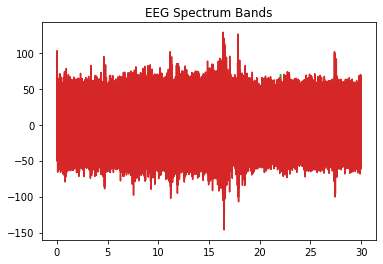

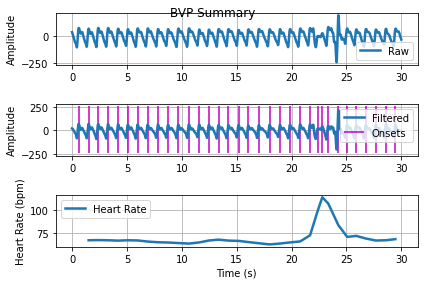

Picking Data Point 1602
(7680,)


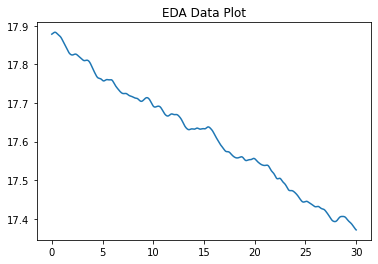

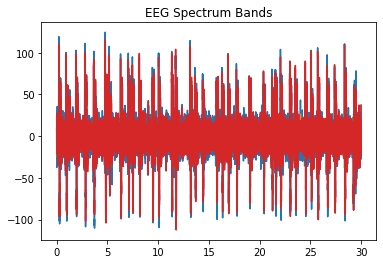

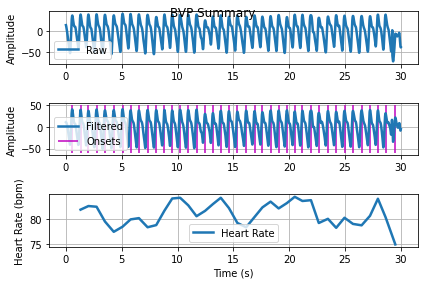

Picking Data Point 1506
(7680,)


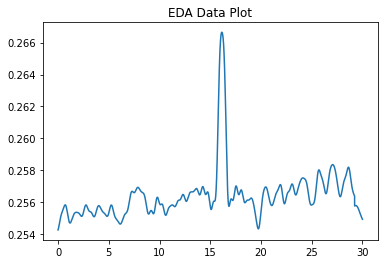

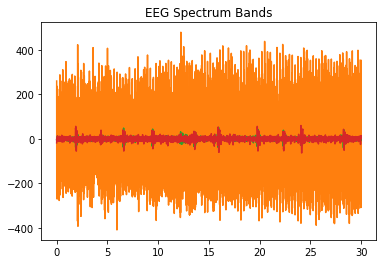

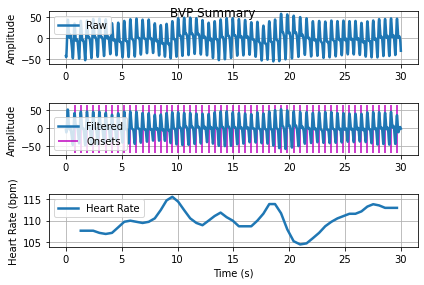

Picking Data Point 1433
(7680,)


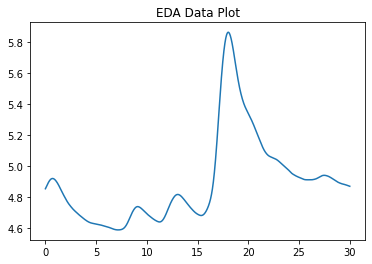

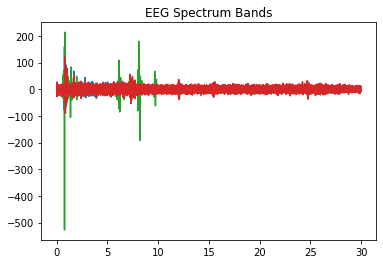

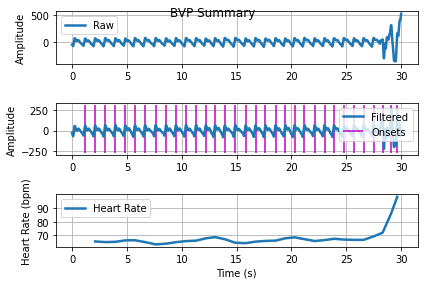

Picking Data Point 1418
(7680,)


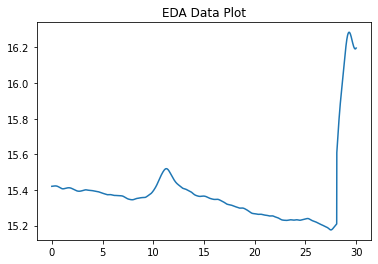

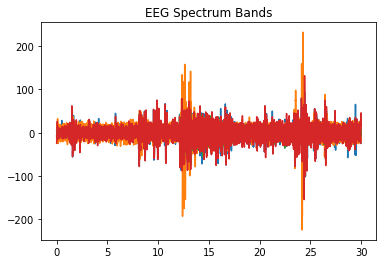

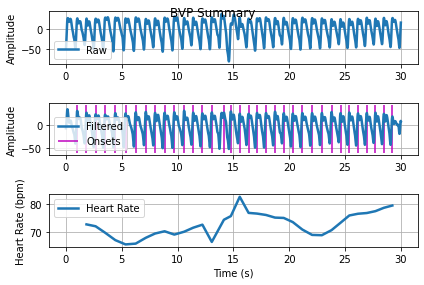

Picking Data Point 1356
(7680,)


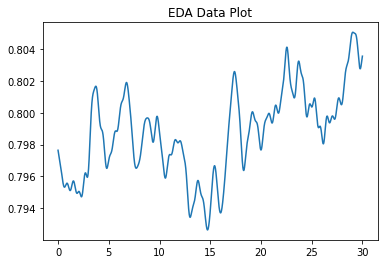

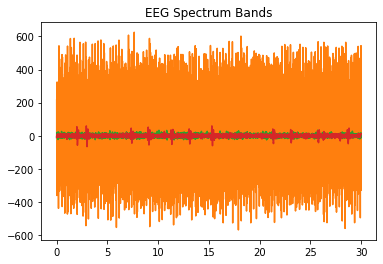

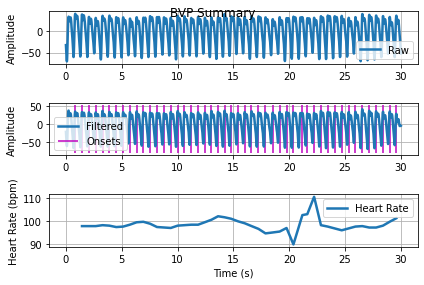

Picking Data Point 1285
(7680,)


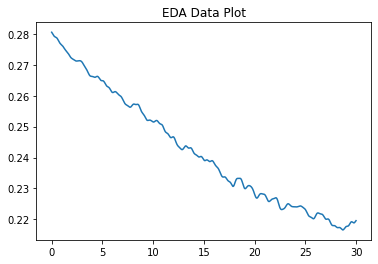

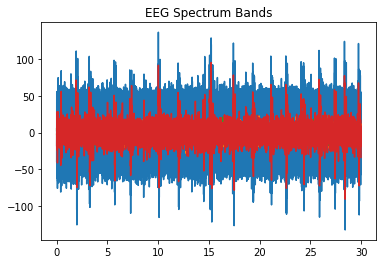

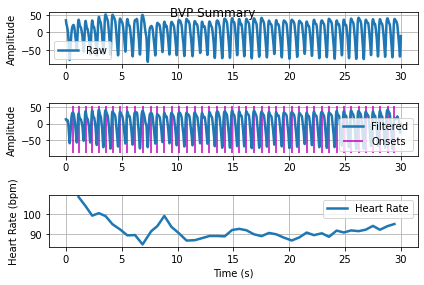

Picking Data Point 1238
(7680,)


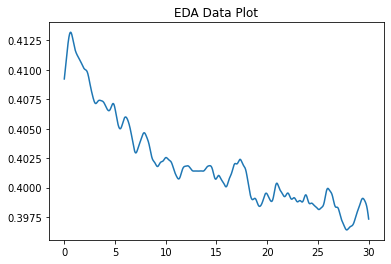

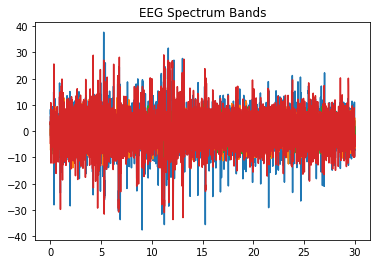

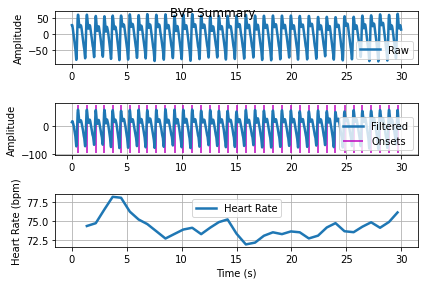

Picking Data Point 1207
(7680,)


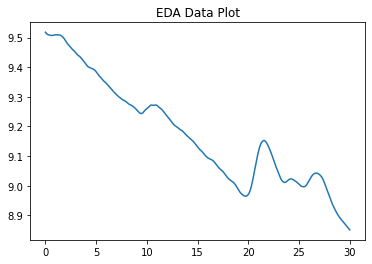

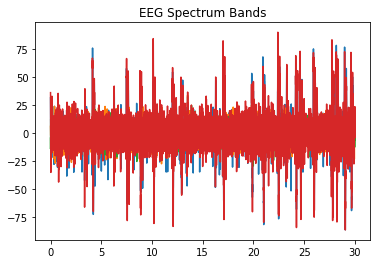

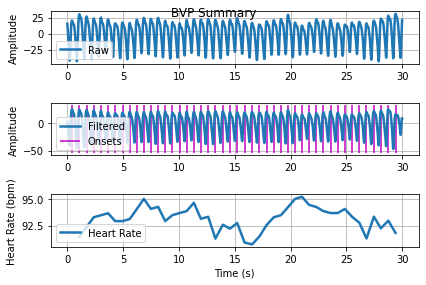

Picking Data Point 1063
(7680,)


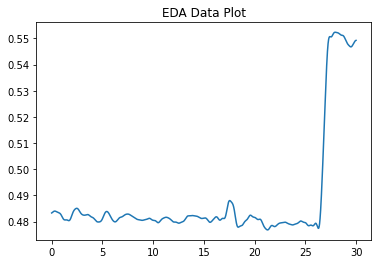

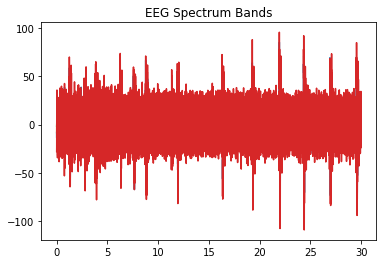

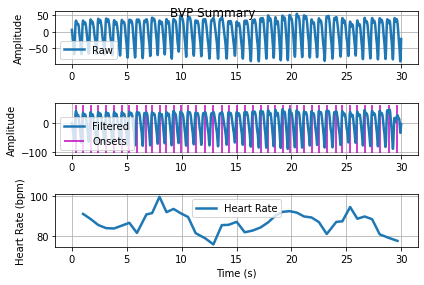

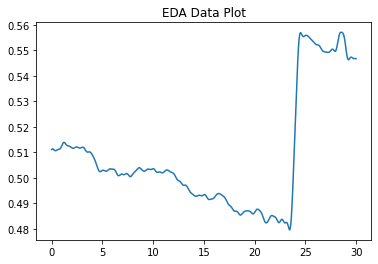

In [113]:
#Testing Data Integrity:
signals_of_interest = ['FILT_TP9', 'FILT_AF7', 'FILT_AF8', 'FILT_TP10','HR_EMPATICA','EDA_EMPATICA','BVP_Filt']

bad_data = [ 530,  788,  828,  965, 1063, 1207, 1238, 1285, 1356, 1418, 1433,
       1506, 1602, 1722]

for _ in range(10):
    i = bad_data.pop()
    # i = np.random.randint(0,len(X_train))
    print(f"Picking Data Point {i}")
    eeg_data = X_train[i,:,:-3]
    plt.figure()
    plt.plot([i/256 for i in range(len(eeg_data))],eeg_data)
    plt.title("EEG Spectrum Bands")
    bvp_data = X_train[i,:,np.array(signals_of_interest) == 'BVP_Filt'].flatten()
    print(bvp_data.shape)
    _, _, _, _, heart_rate = bvp(bvp_data,256,show=True)
    eda_data = X_train[i,:,np.array(signals_of_interest) == 'EDA_EMPATICA'].flatten()
    plt.figure()
    plt.plot([i/256 for i in range(len(eda_data))],eda_data)
    plt.title("EDA Data Plot")

In [112]:
print("Xtrain shape: ", X_train.shape, "Xtest shape: ", X_test.shape, "ytrain shape: ", y_train.shape, "xtrain shape: ", y_test.shape)

Xtrain shape:  (2859, 7680, 7) Xtest shape:  (714, 7680, 7) ytrain shape:  (2859, 9) xtrain shape:  (714, 9)


In [111]:
print("train nans: ", np.where(np.isnan(X_train)))
print("train label nans: ", np.where(np.isnan(y_train)))
print("test nans: ", np.where(np.isnan(X_test)))
print("test label nans: ", np.where(np.isnan(y_test)))

train nans:  (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
train label nans:  (array([], dtype=int64), array([], dtype=int64))
test nans:  (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
test label nans:  (array([], dtype=int64), array([], dtype=int64))


In [103]:
nan_in_test

array([  3,   3,   3, ..., 715, 715, 715])

In [101]:
np.where(np.isnan()

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [94]:
X_train[np.unique(nan_vals[0]),:,:][:,:,np.unique(nan_vals[2])].shape

(21, 7680, 4)

In [8]:
dimport tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D, DepthwiseConv1D, SeparableConv1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [114]:
def PhysioCNN(nb_classes, Chans = 7, Samples = 256,
             dropoutRate = 0.5, kernLength = 64,
             D = 1, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """
    SSVEPNet is a convolutional neural network that uses depthwise and separable
    convolutions to predict SSVEP signals

    nb_classes: int,number of classes that will be predicted
    Chans: int, the number of channels of EEG data
    Samples: int, the number of samples per EEG signal
    dropoutRate: foat, the dropout rate before the flattening layer
    kernelLength: int, the length of the 1D convolutions
    D: int, specifies the depth multiplier for first 1D convolution
    F2: int, number of filters in the second layer
    norm_rate: float, the normalization rate
    dropoutType: str, type of Dropout

    return: The Model built with tensorflow
    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Samples, Chans))
    block1       = DepthwiseConv1D(kernLength, use_bias = False,
                                   depth_multiplier = D,padding='same')(input1)
    block2       = SeparableConv1D(F2,kernLength,
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling1D(4)(block2)
    block2       = SeparableConv1D(F2,int(kernLength/2),
                                   use_bias = False, padding = 'same')(block2)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling1D(4)(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('linear', name = 'linear')(dense)

    return Model(inputs=input1, outputs=softmax)

In [115]:
PhysioCNN_model = PhysioCNN(9, Samples = 7680,kernLength = 64)

In [32]:
PhysioCNN_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7680, 7)]         0         
                                                                 
 depthwise_conv1d_4 (Depthwi  (None, 7680, 7)          448       
 seConv1D)                                                       
                                                                 
 separable_conv1d_8 (Separab  (None, 7680, 16)         560       
 leConv1D)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 7680, 16)         64        
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 7680, 16)          0         
                                                           

In [116]:
PhysioCNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss= 'mean_squared_error')

number_of_iterations = 1000
batch_size = 32
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = PhysioCNN_model.fit(X_train, y_train, batch_size=32, epochs=number_of_iterations,validation_data=(X_test,y_test))

Epoch 1/1000
90/90 [==============================] - 80s 875ms/step - loss: 1.3066 - val_loss: 1.6355
Epoch 2/1000
90/90 [==============================] - 78s 872ms/step - loss: 1.0209 - val_loss: 1.1478
Epoch 3/1000
90/90 [==============================] - 79s 873ms/step - loss: 0.9927 - val_loss: 1.0313
Epoch 4/1000
90/90 [==============================] - 79s 874ms/step - loss: 0.9811 - val_loss: 1.0767
Epoch 5/1000
90/90 [==============================] - 79s 874ms/step - loss: 0.9684 - val_loss: 1.0215
Epoch 6/1000
90/90 [==============================] - 79s 873ms/step - loss: 0.9664 - val_loss: 1.0459
Epoch 7/1000
90/90 [==============================] - 79s 874ms/step - loss: 0.9539 - val_loss: 1.0205
Epoch 8/1000
90/90 [==============================] - 79s 873ms/step - loss: 0.9477 - val_loss: 0.9925
Epoch 9/1000
90/90 [==============================] - 79s 873ms/step - loss: 0.9396 - val_loss: 0.9939
Epoch 10/1000
90/90 [==============================] - 78s 872ms/step - l

KeyboardInterrupt: ignored

In [117]:
PhysioCNN_model.save('/content/drive/MyDrive/School/MIT Spring2022/18.065/18065 Project/Models/PhysioCNN_model_64_7680/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/School/MIT Spring2022/18.065/18065 Project/Models/PhysioCNN_model_64_7680/assets


### Code to test smaller samples of the data

In [ ]:
with open(r"C:\Users\nelso\Desktop\18065 Project Data\Emognition\22\22_BASELINE_STIMULUS_MUSE.json") as json_file:
    eeg_data = json.load(json_file)

In [ ]:
for eeg_chan in ['FILT_TP9', 'FILT_AF7', 'FILT_AF8', 'FILT_TP10']:
    filtered_eeg = eeg_analysis(eeg_data)[0][eeg_chan]
    plt.figure()
    plt.plot([i/256 for i in range(len(eeg_df))],filtered_eeg)
    plt.title(f"EEG RAW Data {eeg_chan}")

filtered_eeg shape:  (30739,)
[ 35.15819602 189.76799187 431.44915043 ...  -1.8485881   -1.38779581
   1.24229346]
filtered_eeg shape:  (30739,)
[ 34.33975295 185.97486991 425.18208225 ...   6.48738635   3.89985449
   1.91576813]
filtered_eeg shape:  (30739,)
[ 3.46009575e+01  1.86950169e+02  4.25064290e+02 ... -6.36177604e+00
 -4.16509376e+00  7.10090294e-02]
filtered_eeg shape:  (30739,)
[ 34.89699146 188.70562466 430.05191096 ...  -8.08749227  -5.40383918
  -1.55377611]
filtered_eeg shape:  (30739,)
[ 35.15819602 189.76799187 431.44915043 ...  -1.8485881   -1.38779581
   1.24229346]
filtered_eeg shape:  (30739,)
[ 34.33975295 185.97486991 425.18208225 ...   6.48738635   3.89985449
   1.91576813]
filtered_eeg shape:  (30739,)
[ 3.46009575e+01  1.86950169e+02  4.25064290e+02 ... -6.36177604e+00
 -4.16509376e+00  7.10090294e-02]
filtered_eeg shape:  (30739,)
[ 34.89699146 188.70562466 430.05191096 ...  -8.08749227  -5.40383918
  -1.55377611]
filtered_eeg shape:  (30739,)
[ 35.15819602 

In [ ]:
eeg_df = pd.DataFrame.from_dict(eeg_data)
eeg_df.columns

In [ ]:
for eeg_chan in ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']:
    plt.figure()
    filtered_eeg = butter_bandpass_filter(eeg_df[eeg_chan], 5, 55, 256, order=4)
    plt.plot([i/256 for i in range(len(eeg_df))],filtered_eeg)
    plt.title(f"EEG RAW Data {eeg_chan}")

In [ ]:
window = 30
seconds_of_data = window - 20 #window minus overlap
print("Training samples: ",2*60*256/(256*seconds_of_data)*64*0.9)
print("Training with augmentation: ", 2*2*60*256/(256*seconds_of_data)*64*0.9)
print("Testing samples: ",2*60*256/(256*seconds_of_data)*64*0.1)

Training samples:  691.2
Training with augmentation:  1382.4
Testing samples:  76.80000000000001


In [ ]:
#Calculations to ensure sampling rate and time of recordings match
approx_samp_rate_subject20 = 64*(30739/7680)
approx_exp_duration_subject20 = 30739/256/60